# Auxiliary tutorial 3: A discussion on priors

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](aux3_priors.ipynb). It may also be viewed [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/aux3_priors.ipynb).*

In [45]:
import numpy as np
import numba
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

%matplotlib inline

import bokeh
import ipywidgets
bokeh.io.output_notebook()

Loading BokehJS ...

In this tutorial, we will discuss **prior** probability distributions. Recall that in the context of parameter estimation, we can write Bayes's theorem as

\begin{align}
P(\mathbf{a}\mid D, I) = \frac{P(D\mid \mathbf{a},I)\,P(\mathbf{a}\mid I)}{P(D\mid I)},
\end{align}

where $D$ is our data set and $\mathbf{a}$ is the set of parameters. The prior probability is $P(\mathbf{a}\mid I)$, and it must be specified in order to compute a posterior. We will discuss how we can specify the priors and the consequences of how we specify them. We will do four exercises.

1. Demonstrate with real data that provided your prior is sufficiently flat and you have enough data, the likelihood overwhelms the prior in computing the posterior. In other words, the exact choice of prior has limited effect on the posterior when data are plentiful.
2. Conversely, **informative priors**, those that explicitly take into account previously known information about the parameter values, require many more data for the likelihood to overwhelm them.
3. Discuss what it means to be an **uninformative prior** and why we would want to choose a prior to be uninformative. We will not dwell too long on this in light of point 1.
4. Discuss **conjugate priors**, which have the convenient feature that for a given likelihood, the prior and posterior have the same functional form.

## A demonstration of how priors affect the posterior

To demonstrate the effect of various priors, we will work with the number of minutes of sleep for zebrafish from the experiments from [Tutorial 2a](t2a_managing_data_sets.html). Our goes is to estimate the mean and standard deviation for the number of minutes of sleep of wild type fish on the third night of the experiment. First, we'll load in the data and extract what we need. We'll use the CSV file we generated in [Tutorial 2a](t2a_managing_data_sets.html), which you can download [here](../data/130315_1_minute_intervals.csv).

In [20]:
# This is the tidy data set with the one-minute interval sleep data.
df = pd.read_csv('../data/130315_1_minute_intervals.csv')

# Indices we want
inds = (~df.light) & (df.day == 2) & (df.activity < 1e-5) & (df.genotype == 'wt')

# Pluck our data and count number of sleeping minutes; store as NumPy array
n_sleep_min = df[inds].groupby('fish')['fish'].count().values

# Take a look
n_sleep_min

array([200, 200, 190, 249, 232, 319, 104,  93, 233, 287,  49, 311, 225,
       243, 113, 133, 179])

As in lecture and in [Tutorial 2b](t2b_defining_and_estimating_parameters.html), we will assume that the data all have errors drawn from an independent Gaussian sampling distribution with variance $\sigma^2$.  We do not assume we know what $\sigma$ is.  Defining $x_i$ as the number of minutes of sleep for fish $i$, our likelihood is

\begin{align}
P(D \mid \mu, \sigma, I) = \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^n
\prod_{x_i\in D} \mathrm{e}^{-(x_i - \mu)^2/2\sigma^2},
\end{align}

where $n = |D|$ is the number of points in the data set.  The posterior distribution is then

\begin{align}
P(\mu, \sigma \mid D,I) \propto P(D \mid \mu, \sigma, I)\,P(\mu, \sigma \mid I),
\end{align}

where the latter probability distribution is our prior. We will make plots of the posterior, so it is nice to have some functions available to compute it. Importantly, because of precision issues, we want to compute the log posterior and then exponentiate it. The log posterior is

\begin{align}
\ln P(\mu, \sigma \mid D,I) = \text{constant} + \ln P(D \mid \mu, \sigma, I)
+ \ln P(\mu, \sigma \mid I)
\end{align}

We do not really care about normalization, so we can set the constant to whatever we please to make exponentiation of the logarithm easier.  

Now, let's write some functions to compute the log prior, log likelihood, and log posterior. For now, we will use the prior we have been using in class thus far, a uniform prior on the interval $[\mu_\mathrm{min},\mu_\mathrm{max}]$ on $\mu$ and a Jeffreys prior on the interval $[\sigma_\mathrm{min}, \sigma_\mathrm{max}]$ for  $\sigma$.

\begin{align}
P(\mu,\sigma \mid I) &= P(\mu \mid I)\,P(\sigma \mid I) \\[1em]
&= \left\{
\begin{array}{cl}
\left(\sigma(\mu_\mathrm{max}-\mu_\mathrm{min})\ln\left(\sigma_\mathrm{max}/\sigma_\mathrm{min}\right)\right)^{-1} & \text{for }\mu_\mathrm{min} < \mu < \mu_\mathrm{max},\;\sigma_\mathrm{min} < \sigma < \sigma_\mathrm{max},\\[1em]
0 & \text{otherwise}.
\end{array}
\right.
\end{align}

In [21]:
@numba.jit(nopython=True)
def log_prior(mu, sigma, mu_range, sigma_range):
    """
    Log of the unnormalized prior for a single mu and sigma with
    a Jeffreys prior for sigma and uniform prior on mu_range for mu.
    """
    if (sigma_range[0] < sigma < sigma_range[1]) \
                    and (mu_range[0] < mu < mu_range[1]):
        return -np.log(sigma)
    else:
        return -np.inf

@numba.jit(nopython=True)
def log_likelihood(data, mu, sigma):
    """
    Log of the unnormalized likelihood for a single mu and sigma 
    for Gaussian distributed data.
    """
    return -((data - mu)**2).sum() / (2 * sigma**2) - len(data) * np.log(sigma)


def log_posterior(mu, sigma, log_likelihood_fun, log_prior_fun, data, args=()):
    """
    Compute log posterior for a given value of mu and sigma.
    """
    lp = log_prior_fun(mu, sigma, *args)
    if lp == -np.inf:
        return -np.inf
    else:
        return lp + log_likelihood_fun(data, mu, sigma)

    
def log_posterior_all(mu, sigma, log_likelihood_fun, log_prior_fun, 
                      data, args=()):
    """
    Compute the log posterior for array of mu's and sigma's.
    """
    log_post = np.empty((len(sigma), len(mu)))
    for i, sig in enumerate(sigma):
        for j, m in enumerate(mu):
            log_post[i, j] = log_posterior(m, sig, log_likelihood_fun, 
                                           log_prior_fun, data, args)
                                

    # Add a constant to log_post to get it close to unity so well-behaved
    # when we exponentiate it.  We don't care about normalization.
    log_post -= log_post.max()

    return log_post

Now, we're going to have to make contour plots and also compute the most probable parameter values as we work through this, so let's write some functions to do that. To compute the most probable parameter values, we are just looking them up from the log posterior; we are not doing numerical optimization.

In [22]:
def plot_contour(ax, mu, sigma, log_post, y_label=r'$\sigma$',
                 title_str=r'$P(\mu,\sigma|D,I)$'):
    """
    Makes a contour plot of the posterior distribution specified by its
    logarithm, log_post.
    """
    ax.contourf(mu, sigma, np.exp(log_post), cmap=plt.cm.Blues, alpha=0.75)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(y_label)
    ax.set_title(title_str)
    return ax

def print_most_prob(mu, sigma, log_post):
    """
    Prints the approximate most probable values of mu and sigma to the 
    screen, given the log of the posterior, log_post.
    """
    most_prob_inds = np.unravel_index(log_post.argmax(), log_post.shape)
    mu_most_prob = mu[most_prob_inds[1]]
    sigma_most_prob = sigma[most_prob_inds[0]]
    print('most probable mu    = {0:.3f} minutes'.format(mu_most_prob))
    print('most probable sigma = {0:.3f} minutes'.format(sigma_most_prob))

Ok, now let's plot the contours and compute the most probable parameter values.

most probable mu    = 197.487 minutes
most probable sigma = 73.367 minutes


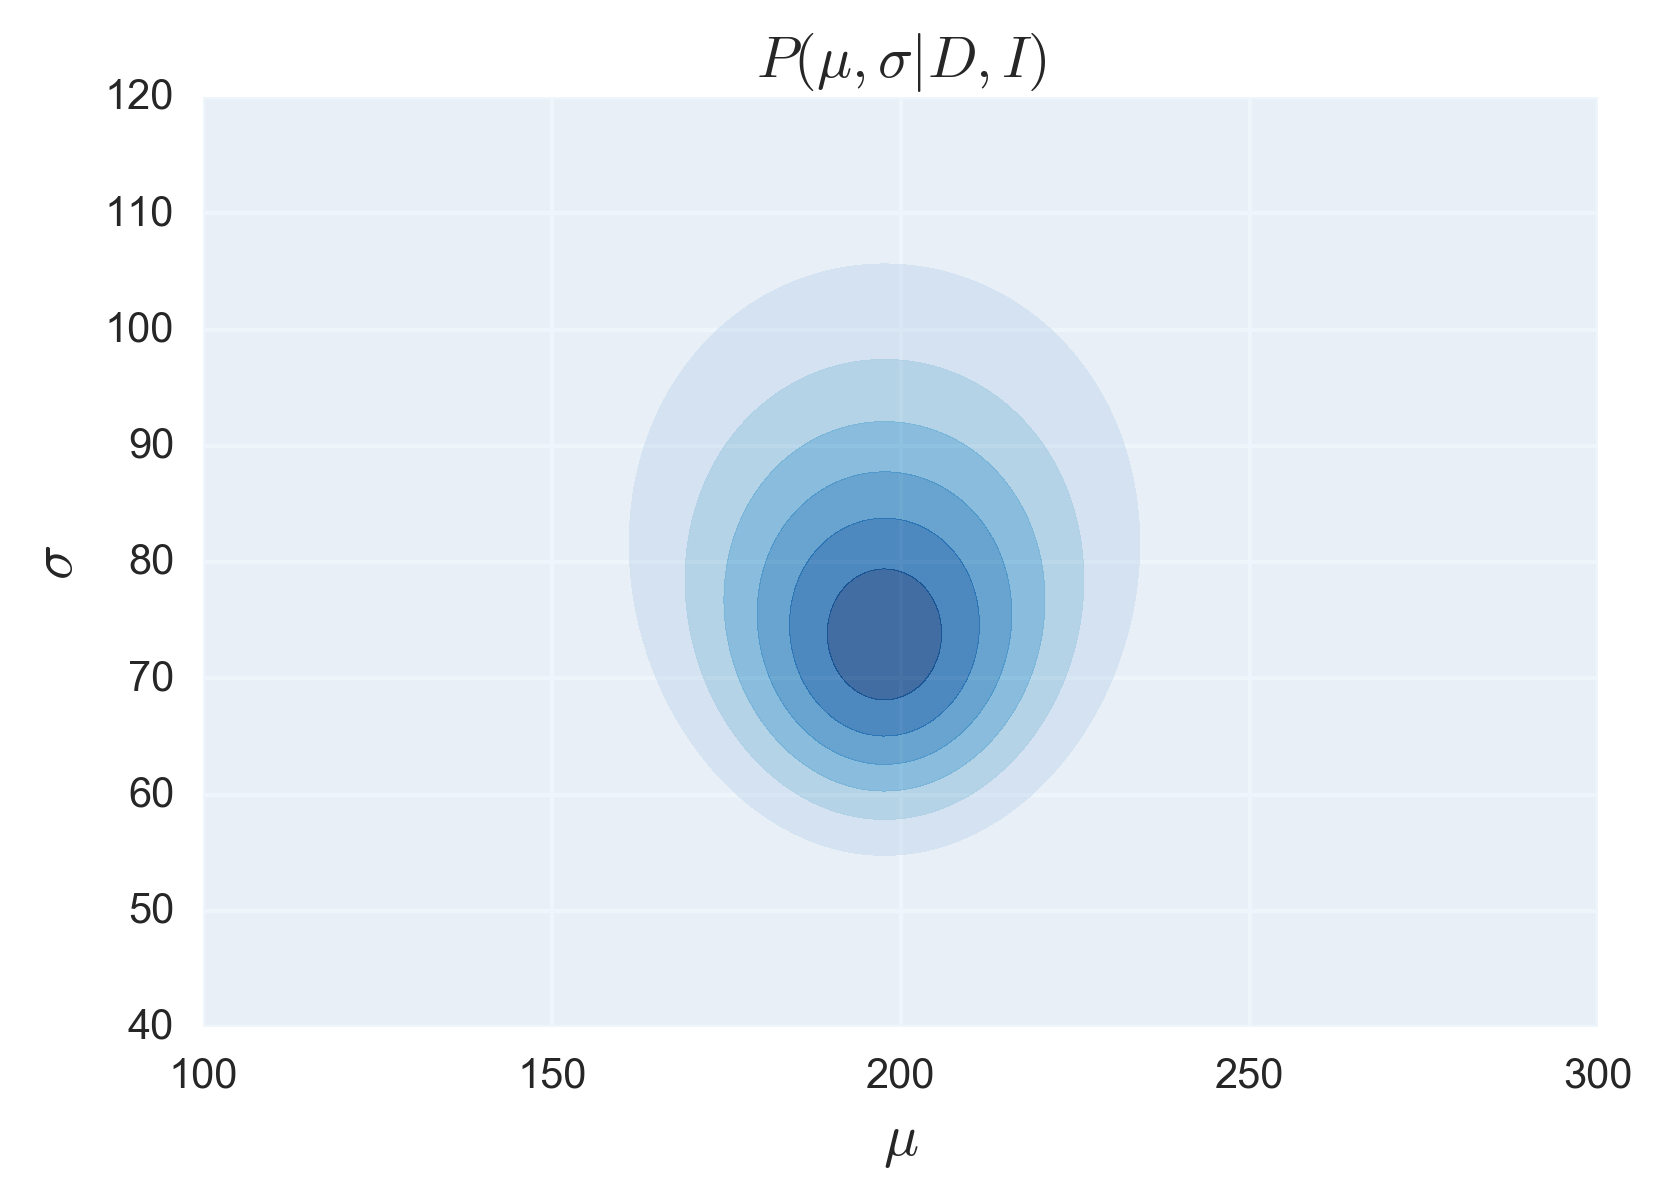

In [23]:
# Ranges to sample parameters
mu = np.linspace(100.0, 300.0, 200)
sigma = np.linspace(40.0, 120.0, 200)

# mu must be positive, and the maximal amount of inactivity is 600 minutes,
# the total duration of the night. Similar considerations for sigma.
mu_range = (0.0, 600.0)
sigma_range = (1.0, 600.0)

# Compute the posterior
log_post = log_posterior_all(mu, sigma, log_likelihood, log_prior, 
                             n_sleep_min, (mu_range, sigma_range))

# Plot the results and print to screen
fig, ax = plt.subplots()
ax = plot_contour(ax, mu, sigma, log_post)
print_most_prob(mu, sigma, log_post)

So, the most probable mean number of minutes slept on the third night is $\mu^* \approx 200$ minutes, or about three hours.  The most probable standard deviation is $\sigma^* \approx 74$ minutes.  Note that this standard deviation is **not** the standard error of the mean.

Now, let's see what happens when we do not have a Jeffreys prior, but rather a flat prior. If the prior is a constant, it contributes an additive constant to the logarithm of the posterior.  Since we do not deal with normalization, we can arbitrarily set the logarithm of this constant to zero.  We can do this for both the uniform prior for $\mu$ and for $\sigma$.

In [24]:
def log_prior_flat(mu, sigma, mu_range, sigma_range):
    """
    Log of flat prior.
    """
    if (sigma_range[0] < sigma < sigma_range[1]) \
                    and (mu_range[0] < mu < mu_range[1]):
        return 0.0
    else:
        return -np.inf    

Now we'll compute the posterior as before, except with the flat prior. We'll plot the two contours side-by-side.

most probable mu    = 197.487 minutes
most probable sigma = 75.377 minutes


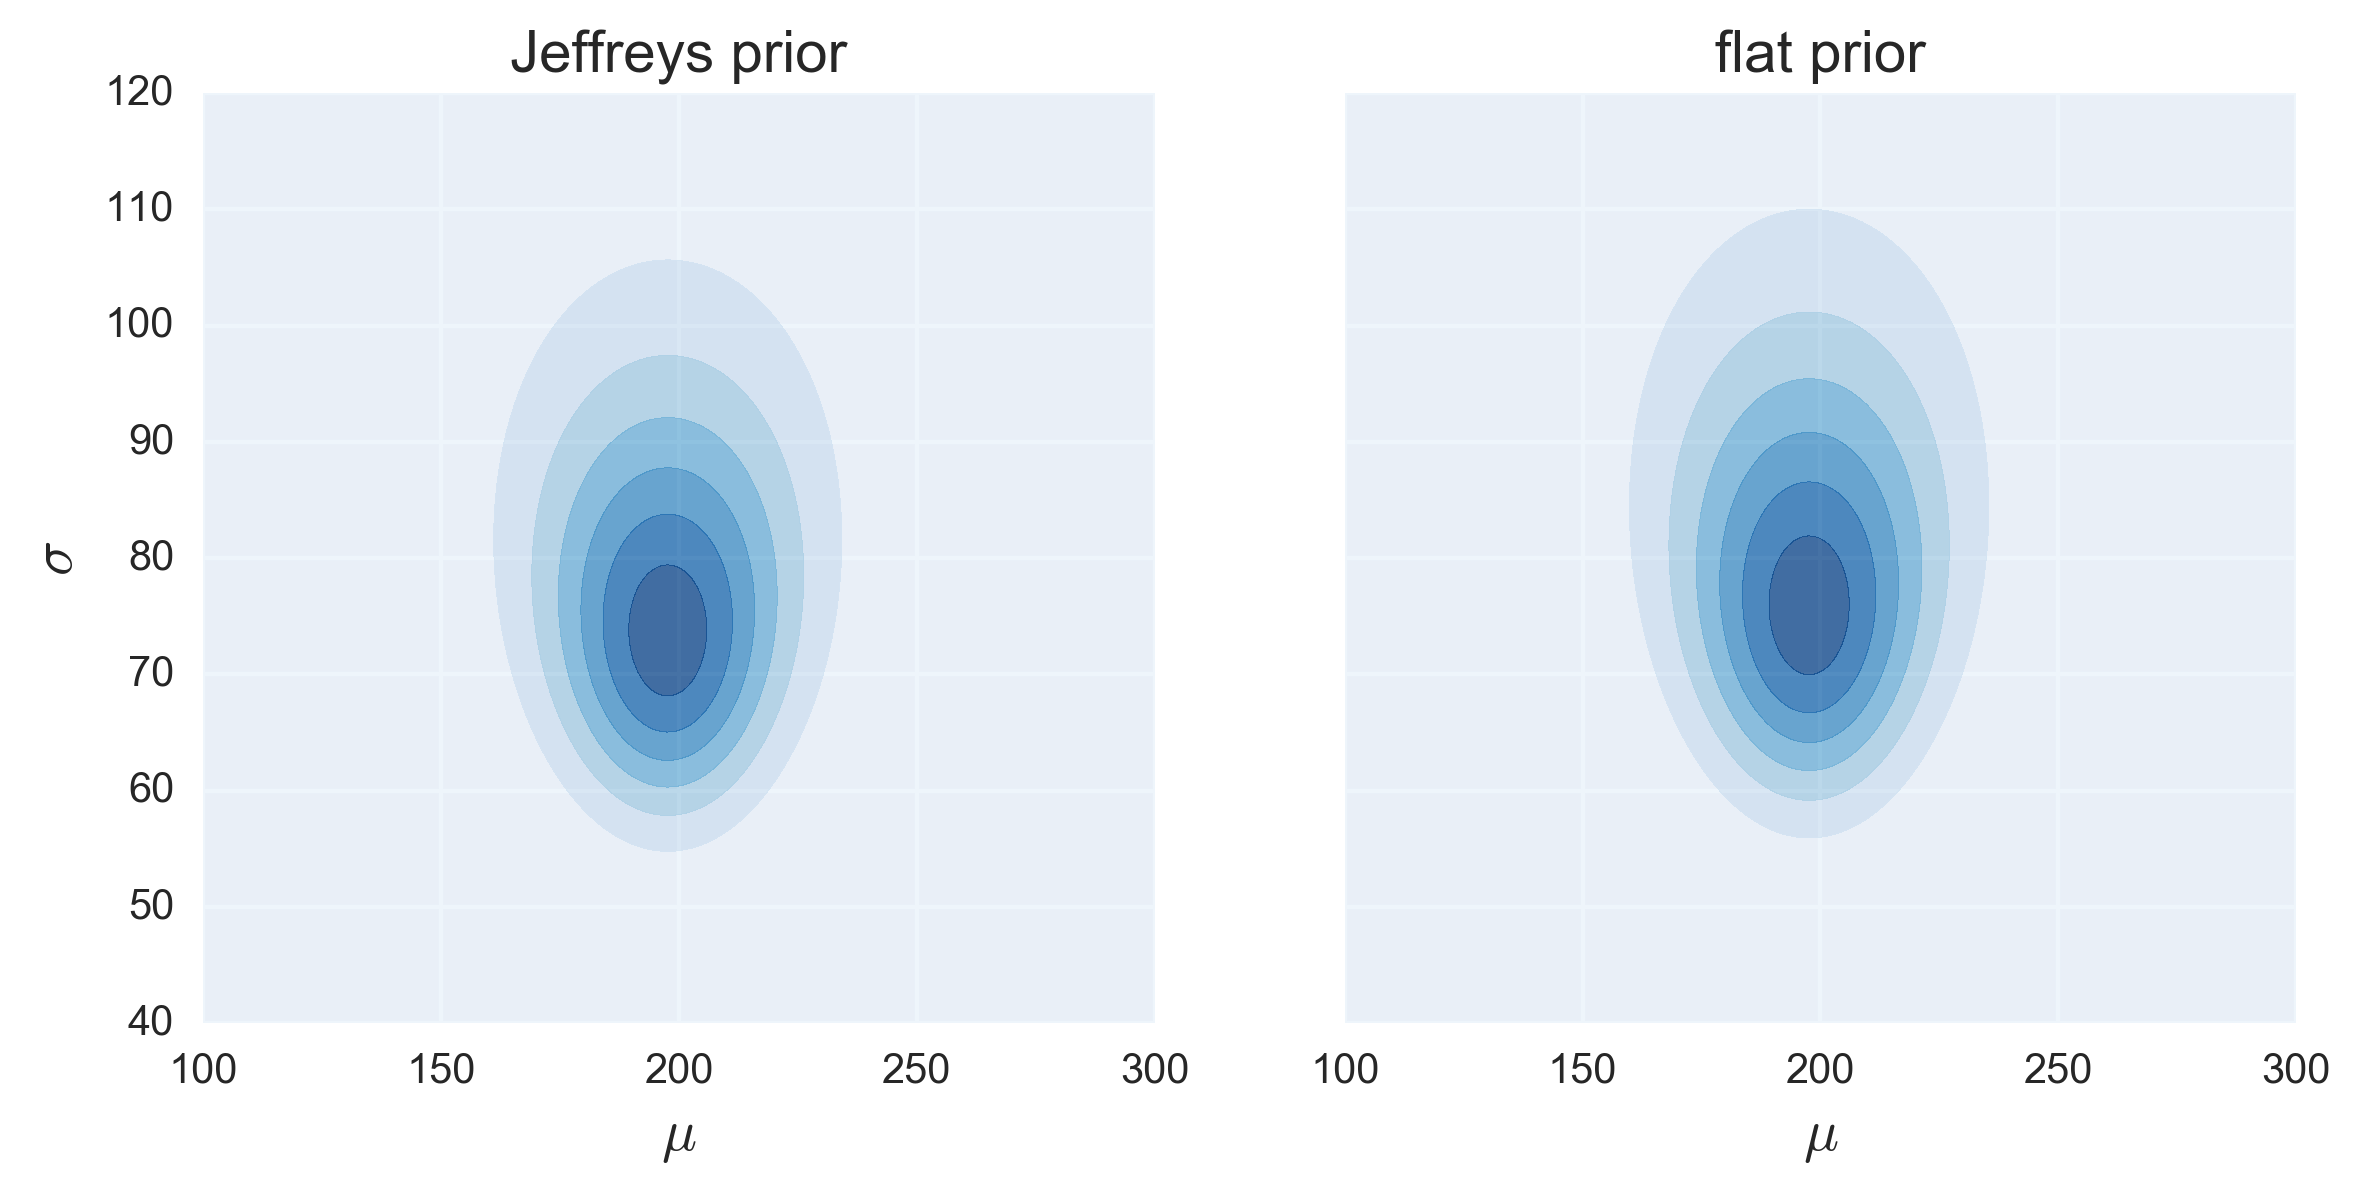

In [25]:
# Compute the posterior, this time with a flat prior
log_post_flat = log_posterior_all(mu, sigma, log_likelihood, log_prior_flat,
                                  n_sleep_min, (mu_range, sigma_range))

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post, 
                     title_str='Jeffreys prior')
ax[1] = plot_contour(ax[1], mu, sigma, log_post_flat, y_label='',
                     title_str='flat prior')
print_most_prob(mu, sigma, log_post_flat)

The most probable value for $\mu$ did not change.  We do see a shift in the most probable value for $\sigma$, though it only changed by about 2%.  The posterior distribution is very similar, with only a small shift in $\sigma$.  So, it does not seem like the Jeffreys prior matters much for the calculation of the posterior.  This can be seen by the relative contributions of each term in the logarithm of the posterior.

\begin{align}
\ln P(\mu,\sigma \mid D,I) = \text{constant} - (n+1) \ln \sigma - \sum_{i\in D}\frac{(x_i - \mu)^2}{2\sigma^2}.
\end{align}

The Jeffreys prior contributed $\log \sigma$ to the log of the posterior.  This is the "$+1$" in the $(n+1)\ln \sigma$ term.  If $n$ is large, $n+1 \approx n$, so the Jeffreys prior does not make much difference.  This is not generally true for all likelihood functions, but is often the case when the likelihood is Gaussian.

## The effects of an informative prior

The parameter estimation did not really change with two different relatively flat priors. Now let's see what happens if we have an **informative prior** for $\mu$. In this case, we will assume that we previously did a measurement and got an estimate for $\mu$ with an error bar. With a Gaussian prior for $\mu$, the prior is now

\begin{align}
P(\mu,\sigma \mid, \mu_\mathrm{prior}, \sigma_\mu, I) \propto \frac{1}{\sigma\,\sigma_\mu}\exp\left[-\frac{(\mu - \mu_\mathrm{prior})^2}{2\sigma_\mu^2}\right].
\end{align}

This gives a log prior of

\begin{align}
ln P(\mu,\sigma\mid \mu_\mathrm{prior}, \sigma_\mu, I) = \text{constant} - \ln \sigma - \ln \sigma_\mu - \frac{(\mu-\mu_\mathrm{prior})^2}{2\sigma_\mu^2}.
\end{align}

We use this function as our log prior and proceed as before.  For this illustration, we will use $\mu_\mathrm{prior} = 225$ minutes and $\sigma_\mu = 150$ minutes.

First, we need to define new prior and posterior functions to handle the informative prior.

most probable mu    = 198.492 minutes
most probable sigma = 73.367 minutes


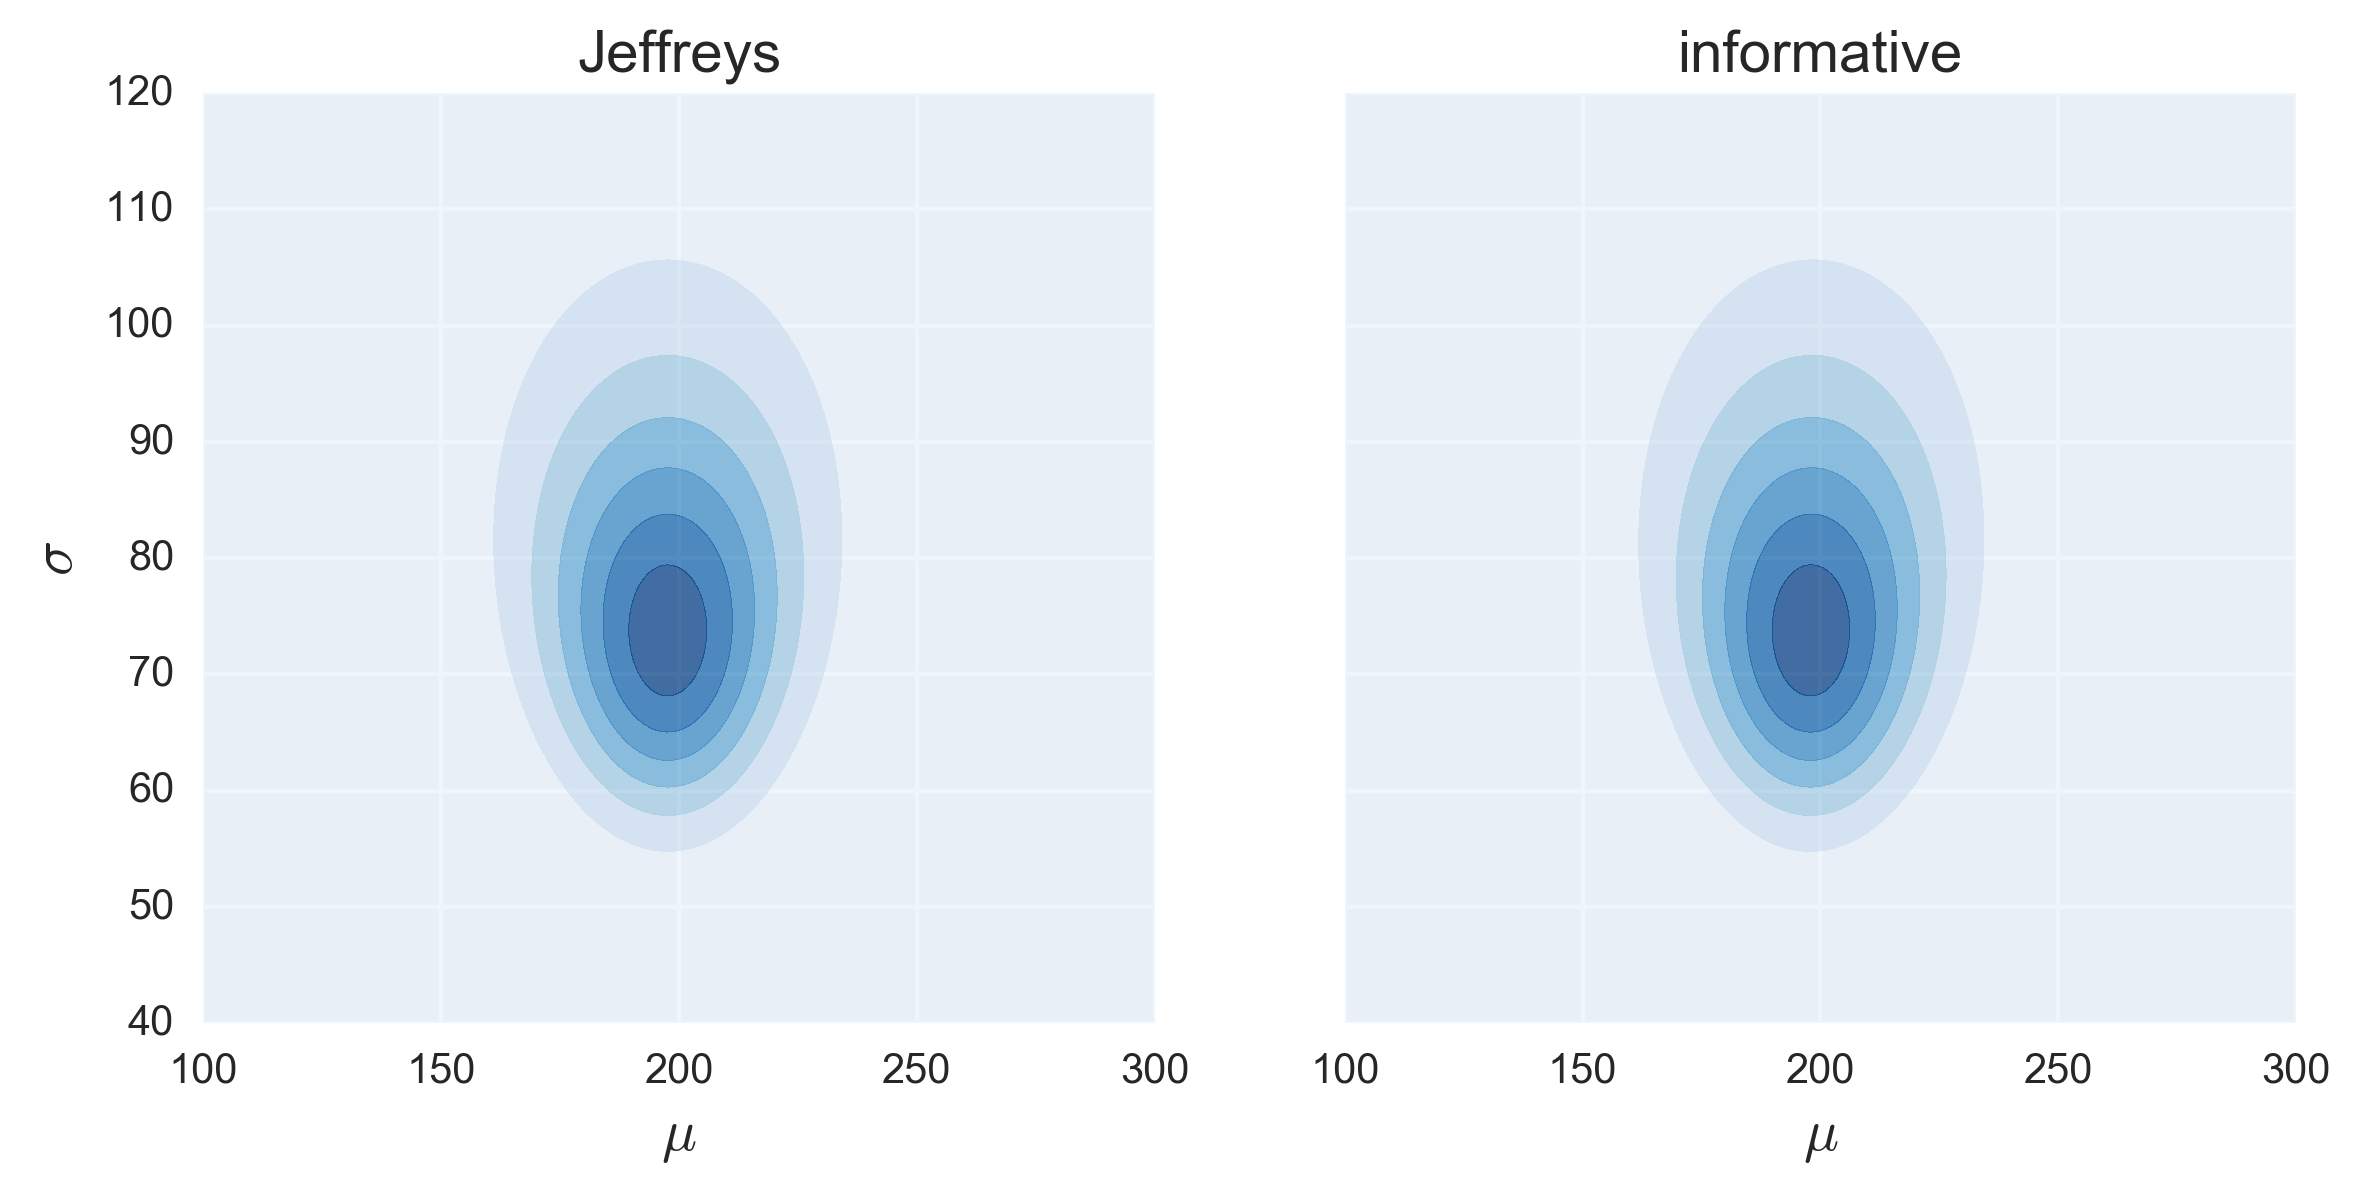

In [38]:
def log_prior_gaussian(mu, sigma, mu_range, sigma_range, mu_prior, sigma_mu):
    """
    Unnormalized informative prior.
    """
    if (sigma_range[0] < sigma < sigma_range[1]) \
                    and (mu_range[0] < mu < mu_range[1]):
        return -np.log(sigma) - np.log(sigma_mu) \
                    - (mu - mu_prior)**2 / 2.0 / sigma_mu**2
    else:
        return -np.inf
    

# Define values of mu_prior and sigma_mu
mu_prior = 225.0
sigma_mu = 150.0
        
# Compute the posterior
log_post_informative = log_posterior_all(
    mu, sigma, log_likelihood, log_prior_gaussian, n_sleep_min, 
    (mu_range, sigma_range, mu_prior, sigma_mu))

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post, 
                     title_str='Jeffreys')
ax[1] = plot_contour(ax[1], mu, sigma, log_post_informative, y_label='',
                     title_str='informative')
print_most_prob(mu, sigma, log_post_informative)

From the plot of the posterior, we see that the informative prior gives almost exactly the same result. The estimate of $\mu$ moved by just one minute, or about one percent. The large standard deviation on the prior led to the prior information being overwhelmed by the data in the likelihood.

Now let's try this again with a standard deviation in the prior of $\sigma_\mu = 20$ minutes. This means we are much more sure of the mean number of sleep minutes from the prior. We need a lot of data, or many measurement with exactly the same number of sleep minutes per night, to overcome this prior.

most probable mu    = 209.548 minutes
most probable sigma = 74.171 minutes


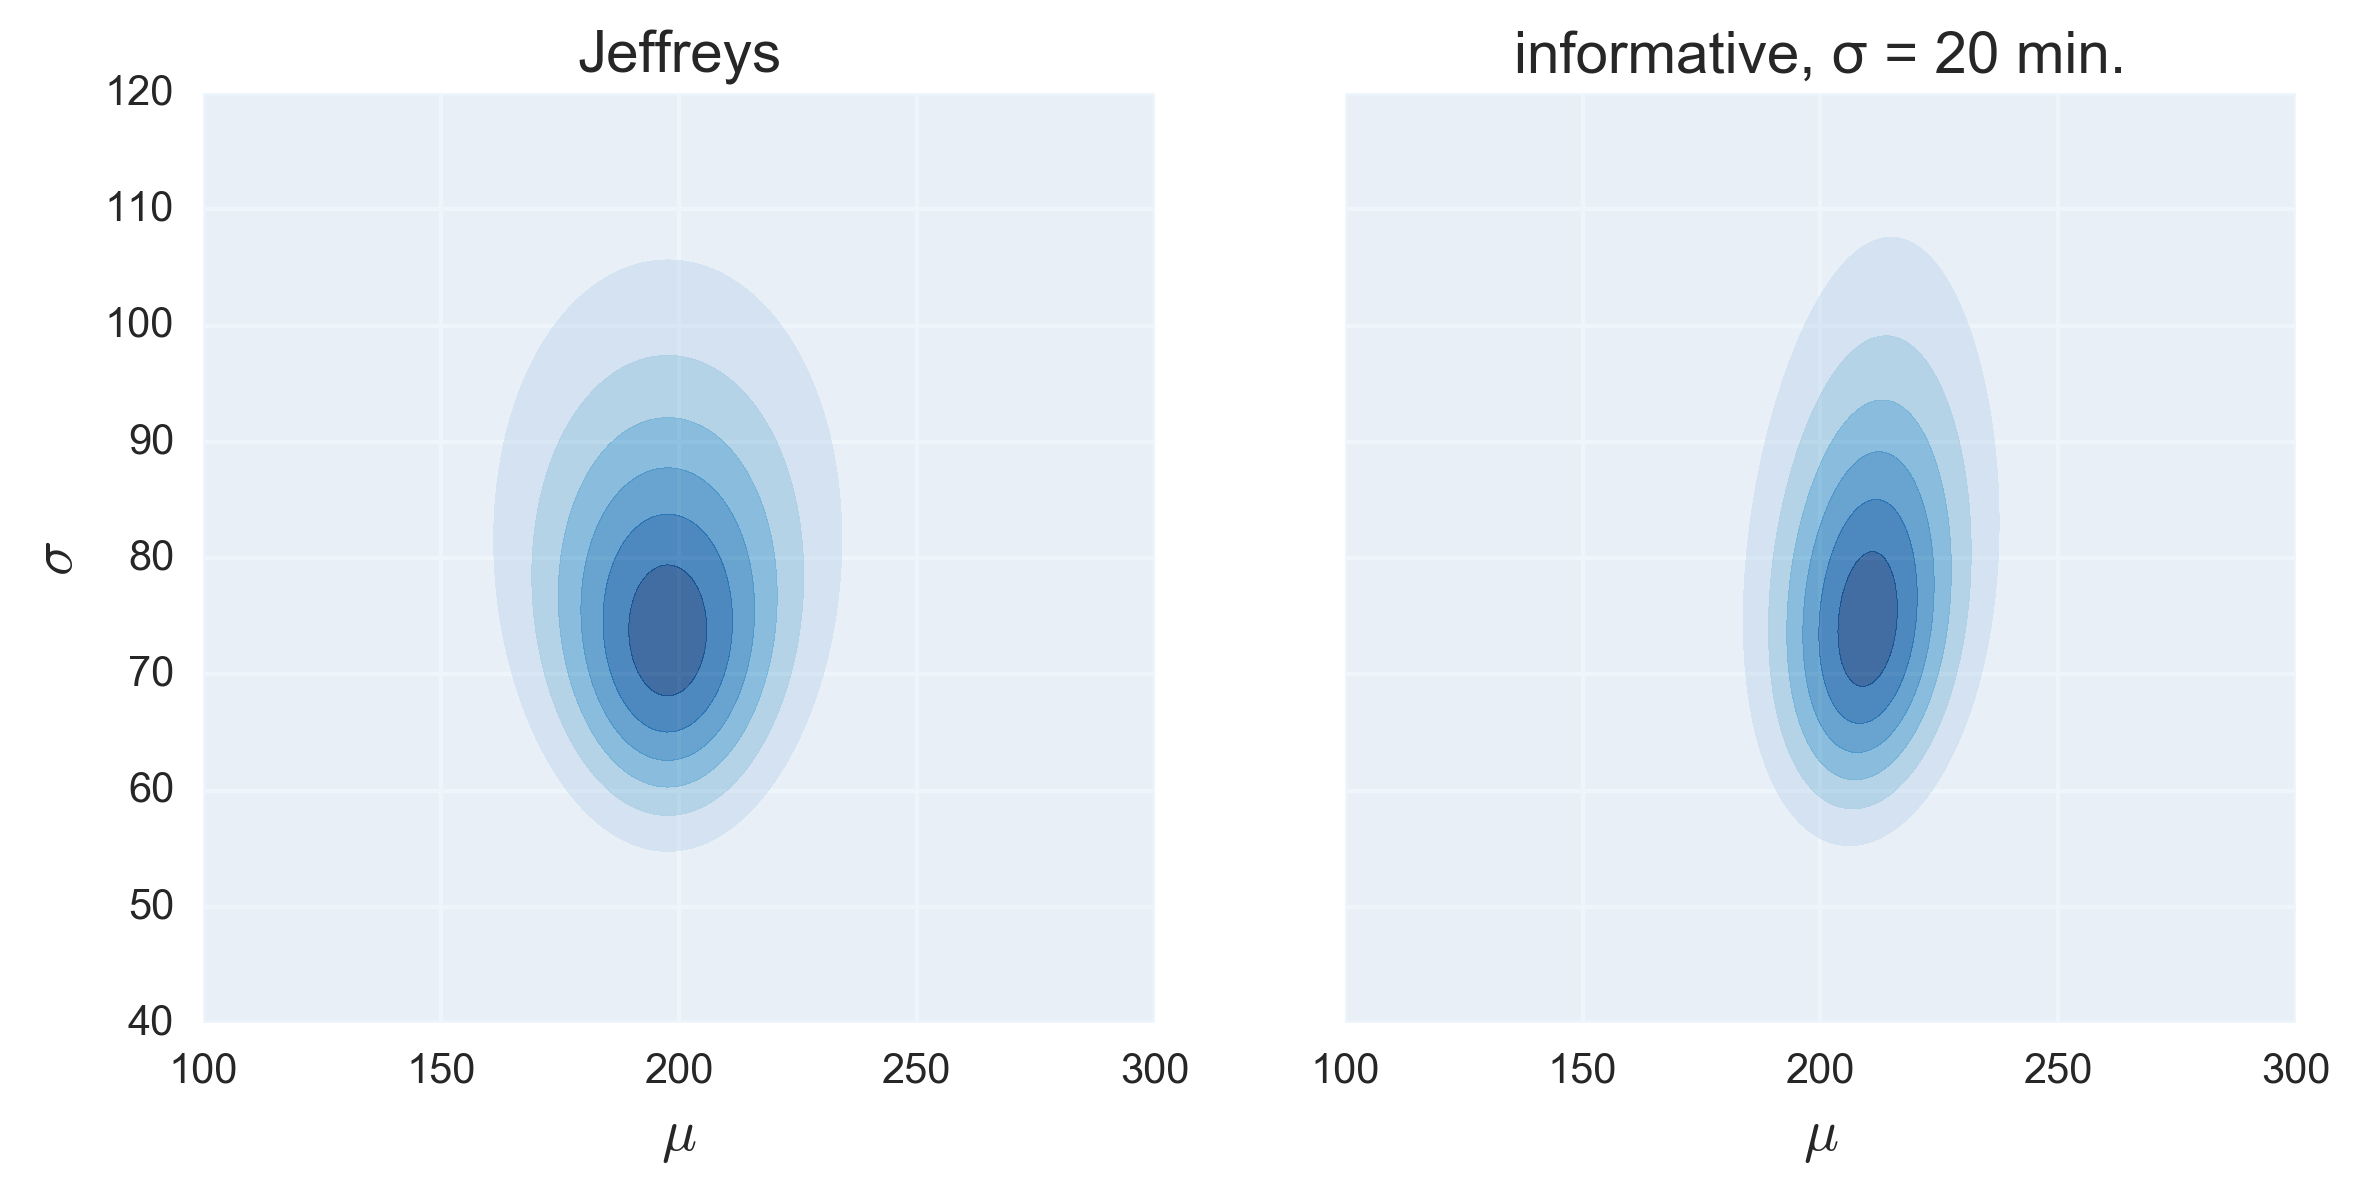

In [41]:
# Reduce sigma_mu to 20 minutes
sigma_mu = 20.0
        
# Compute the posterior
log_post_informative = log_posterior_all(
    mu, sigma, log_likelihood, log_prior_gaussian, n_sleep_min, 
    (mu_range, sigma_range, mu_prior, sigma_mu))

# Plot the results and print to screen
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax[0] = plot_contour(ax[0], mu, sigma, log_post, 
                     title_str='Jeffreys')
ax[1] = plot_contour(ax[1], mu, sigma, log_post_informative, y_label='',
                     title_str='informative, σ = 20 min.')
print_most_prob(mu, sigma, log_post_informative)

The prior, which is a bit at odds with the acquired data, has a stronger influence on our parameter estimate, moving the mean by about 5%.

## Uninformative priors

A prior is **uninformative** if it carries with it no information about the parameter estimates. How we do this in general can be tricky. We should put in some effort to get truly uninformative priors, but, as we have just demonstrated, if we do not exactly get it "right," the implications on the parameter estimation are often small. There are pathological cases where this is not the case, but we're typically pretty safe with broad priors.

That said, I recall a quote from E. T. Jaynes.

>If you fail to specify the prior information, a problem of inference is just as ill-posed as if you had failed to specify the data. In practice, orthodoxy is able to function in spite of this in some problems, by the tacit assumption that an uninformative prior is to be used. Of course, the dedicated orthodoxian will deny vehemently that he is making any such assumption; nevertheless, it is a mathematical fact that his conclusions are what a Bayesian would obtain *from an uninformative prior*. (emphasis ETJ)

Now, what do we mean by **uninformative**? This is a delicate question in general, and we will not really address it directly, but rather say that we wish to state *how* we want to be ignorant about a parameter, and then devise a way to enforce this ignorance. This is best discussed by example.

Saw we have a **location parameter**, $\mu$, such that we wish to be ignorant so that $P(\mu) = P(\mu + c)$, where $c$ is some constant. That is to say, the prior probability of the parameter does not change as we shift its position along the number line. To find a distribution where this is the case, we use the **change of variables formula**.

\begin{align}
P(\mu) = P(\xi)\left|\frac{\mathrm{d}\xi}{\mathrm{d}\mu}\right|.
\end{align}

In out case, $\xi = \mu + c$, so $\left|\mathrm{d}\xi/\mathrm{d}\mu\right| = 1$. A function that trivially satisfies this is $P(\mu) = \text{constant}$. So, we get a uniform prior as uninformative for a location parameter.

A **scale parameter**, $\sigma$, is invariant for changes of scale, so that $P(\sigma) = P(c\sigma)$, where $c$ is a positive constant. Again, we use the change of variables formula, this time with $\xi = c\sigma$.

\begin{align}
P(\sigma) = P(\xi)\left|\frac{\mathrm{d}\xi}{\mathrm{d}\sigma}\right|
= cP(c\sigma).
\end{align}

If we have $P(\sigma) = c/\sigma$, this is satisfied.

\begin{align}
P(\sigma) = \frac{c}{\sigma} = c\left(\frac{c}{c\sigma}\right) = cP(c\sigma).
\end{align}

This prior probability, $P(\sigma) \propto \sigma^{-1}$ is called a **Jeffreys prior** in the physics literature; the statistical literature often refers to a Jeffreys prior more generally. Note that the logarithm of a variable having a Jeffreys prior has a uniform prior, which you can verify again using the change of variables formula.

\begin{align}
P(\sigma) = \frac{c}{\sigma} = P(\ln \sigma)\left|\frac{\mathrm{d}\ln \sigma}{\mathrm{d}\sigma}\right| = \frac{P(\ln \sigma)}{\sigma},
\end{align}

so $P(\ln \sigma) = c$.


### It's not always that simple

Oftentimes, though, finding an uninformative prior is not so simple. Consider this example inspired by [this great blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) by [Jake VanderPlas](http://staff.washington.edu/jakevdp/). 

We will demonstrate why uniform priors are not uninformative in the case of linear regression, consider a line $y = ax + b$.  Let's fix $b$ to be zero.  We make 100 lines with $a$ going in evenly-spaced increments from 0 to 20 and plot the results.  

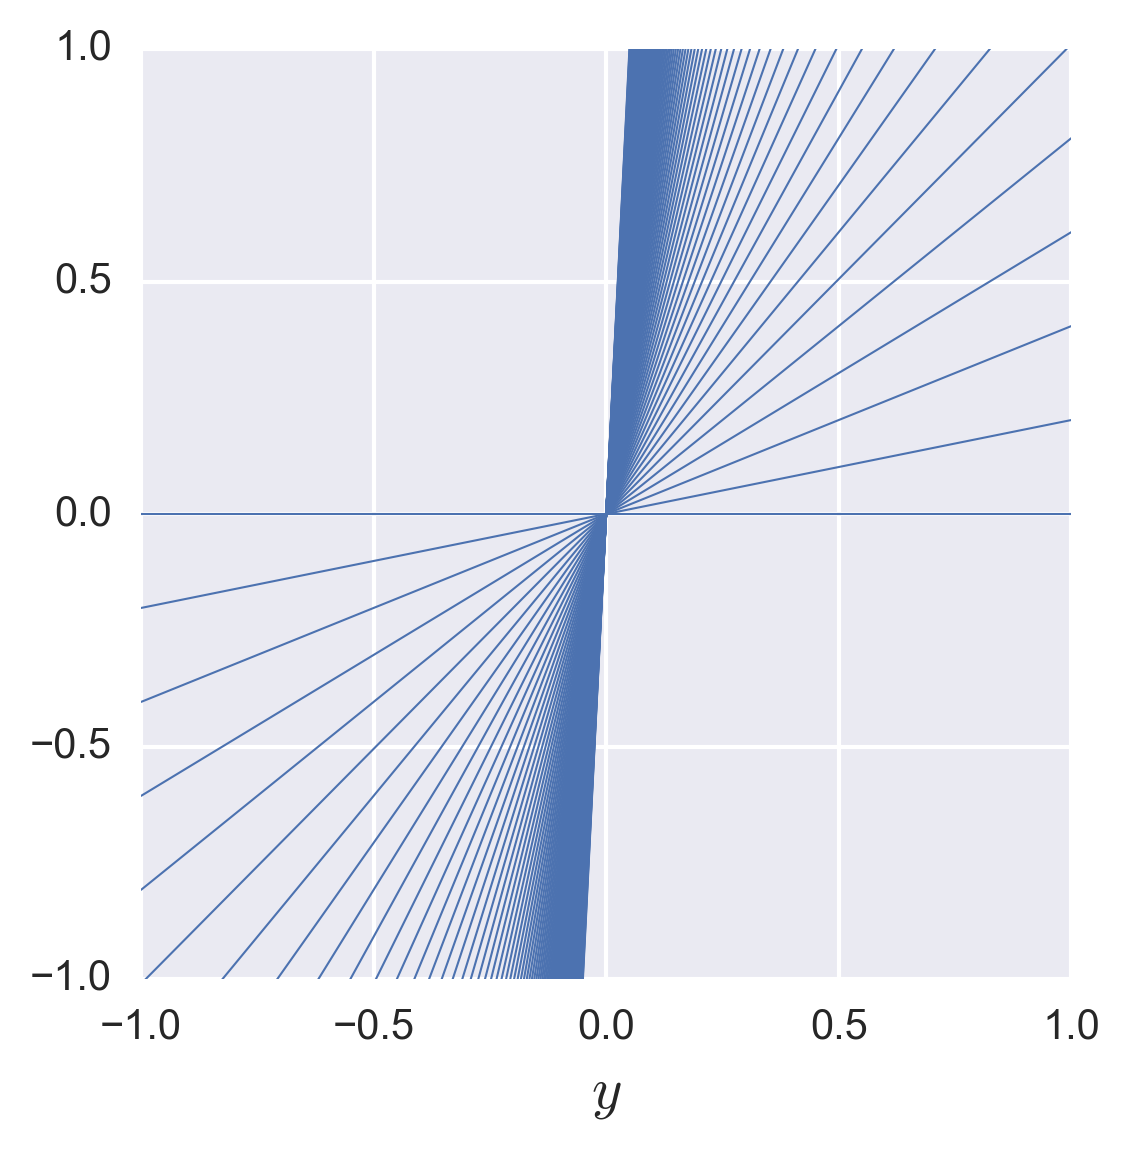

In [30]:
# Make array of slopes
a = np.linspace(0.0, 20.0, 100)

# Make plots, using thin lines
for a_val in a:
    plt.plot([-1, 1], [-a_val, a_val], color=sns.color_palette()[0], lw=0.5)

# Set the axes to be square
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.axes().set_aspect('equal')

# Label axes
plt.xlabel(r'$x$')
plt.xlabel(r'$y$');

We see that higher slopes are strongly favored if we have uniform probability of picking slopes.

Now, we could have arbitrarily chosen to define a line as $y = a x + b$ or $x = \alpha y + \beta$. We do not want this choice to bias the results of our parameter estimation. To enforce this ignorance of choice of parametrization of the line, we use the change of variable formula for multiple variable (discussed in section 3.6 of Sivia) to enforce

\begin{align}
P(a,b \mid I) = P(\alpha,\beta \mid I) \begin{vmatrix}
\frac{\partial \alpha}{\partial a} & \frac{\partial \alpha}{\partial b} \\[1mm]
\frac{\partial \beta}{\partial a} & \frac{\partial \beta}{\partial b}
\end{vmatrix}
\end{align}

where the term $|\cdot|$ denotes the determinant of the Jacobian. Solving the two linear equations for $\alpha$ and $\beta$ in terms of $a$ and $b$ gives

\begin{align}
\alpha &= \frac{1}{a},\\
\beta &= -\frac{b}{a}.
\end{align}

We can then compute the determinant of the Jacobian,

\begin{align}
\begin{vmatrix}
\frac{\partial \alpha}{\partial a} & \frac{\partial \alpha}{\partial b} \\[1mm]
\frac{\partial \beta}{\partial a} & \frac{\partial \beta}{\partial b}
\end{vmatrix}
= \begin{vmatrix}
-\frac{1}{a^2} & 0 \\[1mm]
\frac{b}{a^2} & -\frac{1}{a}
\end{vmatrix}
= \frac{1}{a^3}.
\end{align}

Thus,

\begin{align}
P(a,b \mid I) = a^{-3}\,P(\alpha,\beta \mid I) = a^{-3}\,P\left(\left.\frac{1}{a},-\frac{b}{a}~\right|~I\right).
\end{align}

We now test the expression

\begin{align}
P(a,b \mid I) = \frac{1}{2(1+a^2)^{\frac{3}{2}}}
\end{align}

to see if our unformative condition holds.

\begin{align}
a^{-3}\,P\left(\left.\frac{1}{a},-\frac{b}{a}~\right|~I\right)
&= \frac{1}{2a^3(1+a^{-2})^{\frac{3}{2}}}
= \frac{1}{2\left(\left[a^2(1+a^{-2})\right]^3\right)^{\frac{1}{2}}} \\
&= \frac{1}{2(1+a^2)^{\frac{3}{2}}}
= P(a,b \mid I).
\end{align}

So, the condition to be uninformative holds.  Note that I have included the normalization constant of $1/2$ to make it a proper probability distribution, though that is unnecessary to prove that the form of the prior is uninformative.

So, a properly uninformative prior for a linear regression is uniform in the intercept but has this apparently strange for for the slope.

In summary, I would say that it is important to be uninformative, but being *completely* uninformative can be difficult to achieve, especially for complicated models. It is often safe to just have a broad prior.

We will revisit uninformativeness in the context of conjugate priors a bit later in this tutorial.

## Conjugate priors

In the first lecture, we talked about Bayes theorem as a model for learning. The idea there was that we know something before (*a priori*) acquiring data, and then we update our knowledge after (*a posteriori*). So, we come in with the prior and out with the posterior after acquiring data. It might make sense, then, that the prior and the posterior distributions have the same functional form. When the prior and posterior have the same functional form, the prior is said to be **conjugate** to the likelihood. This makes sense: the likelihood determines the relationship between the prior and the posterior, so it should determine the functional form of the prior/posterior such that they are the same.

Let's consider an example from your upcoming [Homework 4](hw4.html#Problem-4.2:-MCMC-with-Boolean-data-(40-pts)). In that homework, we consider reversals upon exposure to blue light of *C. elegans* that have a Channelrhodopsin in a specific neuron. There is some probability $p$ of reversal. Say we do $n$ trials and observe $r$ reversals. The likelihood is Binomially distributed according to the [story of the Binomial distribution](t3b_probability_stories.html#Binomial-distribution). So, Bayes theorem reads

\begin{align}
P(p\mid n, r, I) = \frac{P(r,n \mid p, I)P(p\mid I)}{P(r,n\mid I)},
\end{align}

where

\begin{align}
P(r,n \mid p, I) = \frac{n!}{(n-r)!r!}\,p^r(1-p)^{n-r}
\end{align}

What functional form can we choose for the prior $P(p\mid I)$ such that the posterior $P(p\mid n, r, I)$ has the same functional form. This requires some serious mathematical work, but the answer is the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). The Beta distribution is

\begin{align}
P(p\mid a, b) = \frac{p^{a-1}(1-p)^{b-1}}{B(a,b)},
\end{align}

where $B(a,b)$ is a [Beta function](https://en.wikipedia.org/wiki/Beta_function),

\begin{align}
B(a,b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}.
\end{align}

Let's take a look at it.

In [61]:
p = np.linspace(0, 1, 200)
pl = bokeh.plotting.figure(height=300, width=400, x_axis_label='p',
                           y_axis_label='P(p;a,b)')

a, b = 1, 1
line = pl.line(p, st.beta.pdf(p, a, b), line_width=2)

def update(a=1, b=1):
    line.data_source.data['y'] = st.beta.pdf(p, a, b)
    bokeh.io.push_notebook()

bokeh.io.show(pl, notebook_handle=True);

In [62]:
ipywidgets.interact(update, a=(0.05, 50), b=(0.05, 50));

So, for $a = b = 1$, we get a uniform distribution, and you can explore the rest with the above widgets. Note, though, that the widgets are not active on the HTML version of this document; you must download and run the Jupyter notebook.

Not, if we insert a Beta distribution for the posterior, we have

\begin{align}
P(p \mid n, r, a, b, I) &= \frac{P(n, r\mid p, I)\, P(p\mid a, b, I)}{P(n, r\mid I)} \\[1em]
&= \frac{1}{P(n,r\mid I)}\,\frac{n!}{(n-r)!r!}\,p^r(1-p)^{n-r}\,\frac{p^{a-1}(1-p)^{b-1}}{B(a,b)} \\[1em]
&= \frac{1}{P(n,r\mid I)\,B(a,b)}\,\frac{n!}{(n-r)!r!}\,p^{r+a-1}(1-p)^{n-r+b-1}.
\end{align}

In looking at this expression, the only bit that depends on $p$ is $p^{r+a-1}(1-p)^{n-r+b-1}$, which is exactly the $p$-dependence of a Beta distribution with parameters $r+a$ and $n-r+b$. Because the posterior must be normalized, the posterior must be a Beta distribution and

\begin{align}
\frac{1}{P(n,r\mid I)\,B(a,b)}\,\frac{n!}{(n-r)!r!} = \frac{1}{B(r+a, n-r+b)}.
\end{align}

We have just normalized the posterior without doing any nasty integrals! So, the posterior is

\begin{align}
P(p \mid n, r, a, b, I) = \frac{p^{r+a-1}(1-p)^{n-r+b-1}}{B(r+a, n-r+b)} = \text{Beta}(r_a, n-r+b).
\end{align}

So, we can see that conjugacy is useful. For a given likelihood, if we know its conjugate prior, we can just immediately write down the posterior in a clear form. The [Wikipedia page on conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) has a useful table of likelihood-conjugate pairs.

Note though that a closed form conjugate does not always exist for a given likelihood, especially for complicated models, and when they do exist, they may be very difficult to find. This does limit their utility. Further, there is no reason why a posterior and prior should have the same functional form; all analysis is completely valid without conjugacy.